This is a noisy trajectory, without weigths

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
os.chdir("..")
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


/tmp/ipykernel_45645/3685532613.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2022-05-17 17:07:38.871249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 17:07:38.892944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 17:07:38.893055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
params, exp_path = def_params()
xi, kappa, omega, eta = params

T = 100.
dt = 1e-2

total_time,dt = T*kappa, kappa*dt


states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

2022-05-17 17:07:47.239192: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 17:07:47.239954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 17:07:47.240127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 17:07:47.240233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

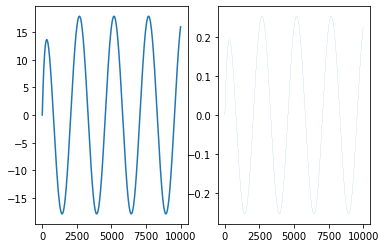

In [3]:
plt.subplot(121)
plt.plot(states_si[:,0])
plt.subplot(122)
plt.plot(tfsignals[0][:,1], linewidth=0.1)

In [5]:
params, exp_path = def_params()

initial_parameters = np.array([10., 4*2*np.pi/total_time]).astype(np.float32)
true_parameters = np.array([10., 4*2*np.pi/total_time]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, initial_states = np.zeros((1,5)).astype(np.float32),
              cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))

In [7]:
preds = model.predict(tfsignals)

2022-05-17 17:08:24.710912: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


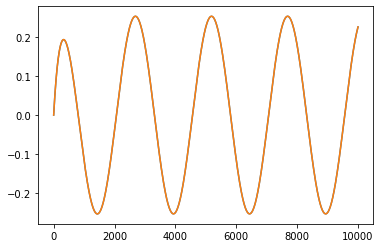

In [40]:
plt.plot(np.squeeze(tfsignals[:,:,1]))
plt.plot(preds[0,:,0])

In [62]:
np.unique(amps)

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  10.        ,  12.91549665,  21.5443469 ,
        35.93813664,  59.94842503, 100.        ])

In [118]:
def logito(A, N=100):
    aa = np.unique(np.sort(list(np.logspace(np.log10(A/100), np.log10(10*A), N)) + [A]))
    return aa

amps = logito(true_parameters[0])
freqs = logito(true_parameters[1])

loss ={}
true_omega = true_parameters[1]
A = true_parameters[0]
for amplitude in tqdm(amps):

    for omega in freqs:
        model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[ amplitude, omega ]]).astype(np.float32)))
        preds = model.predict(tfsignals)
        loss[str([amplitude, omega])] = tf.keras.losses.mse(np.squeeze(tfsignals[:,:,1]), preds[0,:,0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:45:50<00:00, 171.51s/it]


In [120]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
for a in amps:
    for f in freqs:
        ax.scatter(a,f,loss[str([a,f])])

/tmp/ipykernel_45645/2378164696.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Error in callback <function flush_figures at 0x7fb04eff0f70> (for post_execute):



KeyboardInterrupt



In [121]:
np.save("landscape_omega_amplitude", np.array(list(loss.values())))

In [111]:
X,Y = np.meshgrid(amps, freqs)

In [98]:
valls = np.squeeze(list(loss.values()))

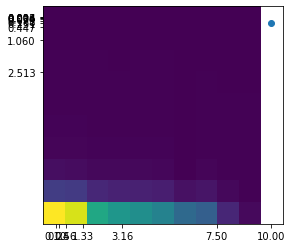

In [107]:
plt.imshow(np.reshape(valls, (10,10)))
plt.xticks(amps)
plt.yticks(freqs)
plt.scatter(*true_parameters)

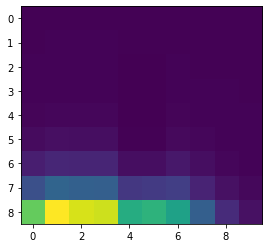

In [96]:
plt.imshow(np.reshape(valls, (9,10)))


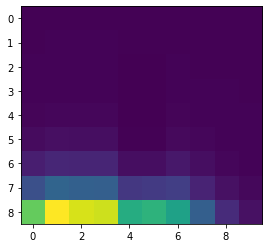

In [80]:
plt.imshow(np.reshape(np.squeeze(list(loss.values())), (9,10)))

TypeError: 'norm' must be an instance of matplotlib.colors.Normalize or None, not a numpy.ndarray

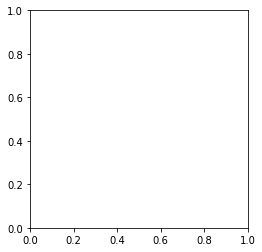

In [79]:
plt.imshow(amps, freqs, np.reshape(np.squeeze(list(loss.values())), (9,10)))

In [73]:
plt.imshow(qa

array([3.0754559e-02, 3.0852439e-02, 3.1133285e-02, 3.1360347e-02,
       2.4591617e-02, 2.4535026e-02, 3.0517811e-02, 3.0469306e-02,
       3.0498883e-02, 3.0442541e-02, 3.1286538e-02, 3.1759184e-02,
       3.2221068e-02, 3.2612164e-02, 2.0497290e-02, 2.0412367e-02,
       3.0927381e-02, 3.0689288e-02, 3.0638654e-02, 3.0496344e-02,
       3.3314705e-02, 3.4571849e-02, 3.5274513e-02, 3.5929881e-02,
       1.4139017e-02, 1.4037686e-02, 3.2344032e-02, 3.1440496e-02,
       3.1023990e-02, 3.0637756e-02, 3.9815865e-02, 4.3368995e-02,
       4.4243146e-02, 4.5281779e-02, 5.7497001e-03, 5.7266196e-03,
       3.7039902e-02, 3.3914827e-02, 3.2141808e-02, 3.1033838e-02,
       6.0530018e-02, 7.1015015e-02, 7.1382485e-02, 7.2828397e-02,
       5.7015288e-05, 5.1280949e-04, 5.2273706e-02, 4.1915044e-02,
       3.5497539e-02, 3.2195512e-02, 1.2631074e-01, 1.5813179e-01,
       1.5503149e-01, 1.5633462e-01, 1.9108560e-02, 2.1490229e-02,
       1.0113039e-01, 6.7526400e-02, 4.5790751e-02, 3.5707477e

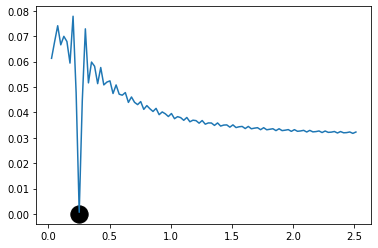

In [55]:
ax=plt.subplot(111)
ax.plot(np.squeeze(list(loss.keys())), np.squeeze(list(loss.values())))
ax.scatter( [true_parameters[1]],[0], color="black",s=300)

In [6]:
spp = tf.split(tfsignals, 50, axis=1)

In [7]:
n_epochs = 10

In [8]:
cc = []
for epoch in range(n_epochs):
    model.reset_states()  
    for k in spp:
        bb = model.train_step((k,k))
        cc+=[bb]
    loss =  np.squeeze(bb["LOSS"].numpy())
    print("\r EPOCH {}/{}   loss:{}    params{}    grads{}".format(epoch, n_epochs,loss, np.squeeze(bb["PARAMS"].numpy()), np.squeeze(bb["GRADS"].numpy())),end="")
    if loss<1e-10:
        break

2022-05-17 16:10:43.783747: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 EPOCH 9/10   loss:0.06193508207798004    params[ 9.124218   -0.25412917]    grads[-0.01976766  5.8980484 ]]1]

In [15]:
def plot_history(cc, preds=None):
    plt.figure(figsize=(20,5))
    if preds is None:

        ax1 = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)       
    else:
        ax1 = plt.subplot(141)
        ax2 = plt.subplot(142)
        ax3 = plt.subplot(143)       
        ax4 = plt.subplot(144)
    
    history_loss = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax1.set_title("LOSS")
    ax1.plot(history_loss)
    ax1.loglog()
    ax1.set_xlabel("GRADIENT STEP")
    
    params=np.squeeze([cc[k]["PARAMS"] for k in range(len(cc))])
    ax2.set_title("PARAMS")
    ax2.plot(params[:,0],label="RNN")
    ax2.plot(np.ones(len(params))*true_parameters[0], '--',label="true")
    ax2.set_xlabel("GRADIENT STEP")
    ax2.legend()
    
    grads = np.squeeze([cc[k]["LOSS"] for k in range(len(cc))])
    ax3.set_title("GRADS")
    ax3.plot(grads)
    ax3.loglog()
    
    
    if preds is not None:
        ax4.set_title("PREDICTIONS")
        ax4.plot(np.squeeze(preds)[:,0], '--',color="red", alpha=0.5,label="RNN")
        ax4.plot(dd[0], color="blue", label="true", alpha=0.5)
        ax4.legend()

In [19]:
freq = 4*2*np.pi/10

In [20]:

model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[10. , freq]]).astype(np.float32)))

<tf.Variable 'UnreadVariable' shape=(1, 2) dtype=float32, numpy=array([[10.       ,  2.5132742]], dtype=float32)>

In [21]:
preds = model.predict(tfsignals)

In [16]:
model.reset_states()
preds = model.predict(tfsignals)

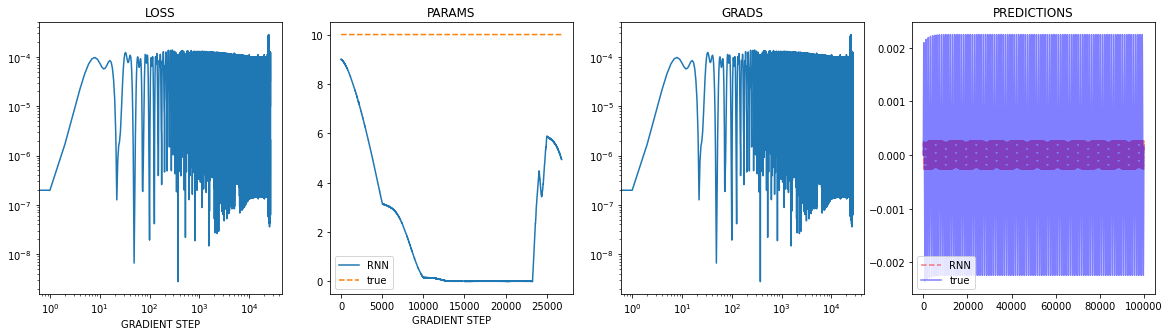

In [17]:
plot_history(cc, preds)

In [12]:
loss = [cc[k]["LOSS"].numpy() for k in range(len(cc))]
grads = np.squeeze([cc[k]["GRADS"].numpy() for k in range(len(cc))])
params = np.squeeze([cc[k]["PARAMS"].numpy() for k in range(len(cc))])